In [1]:
import numpy as np
import pandas as pd
import os

# visualize 
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from matplotlib.dates import DateFormatter
import seaborn as sns

# working with dates
from datetime import datetime

# to evaluate performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 

# for tsa 
import statsmodels.api as sm

# holt's linear trend model. 
from statsmodels.tsa.api import Holt

# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

import QMCBT_01_acquire as acquire
import QMCBT_02_prepare as prepare

# Modelling Exercises
The end result of this exercise should be a Jupyter notebook named model.

<div class="alert alert-success">


# ```SAAS``` dataset

## Acquire

In [2]:
# Read in saas data from cache or Codeup server then write to cache
filename = 'saas.csv'
    
if os.path.isfile(filename):
    df = pd.read_csv(filename)
else:
    url = 'https://ds.codeup.com/saas.csv'
    df = pd.read_csv(url)
    df.to_csv('saas.csv', index=False)

In [3]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,790448,790449,790450,790451,790452,790453,790454,790455,790456,790457
Month_Invoiced,2014-01-31,2014-01-31,2014-01-31,2014-01-31,2014-01-31,2014-01-31,2014-01-31,2014-01-31,2014-01-31,2014-01-31,...,2017-12-31,2017-12-31,2017-12-31,2017-12-31,2017-12-31,2017-12-31,2017-12-31,2017-12-31,2017-12-31,2017-12-31
Customer_Id,1000000,1000001,1000002,1000003,1000004,1000005,1000006,1000007,1000008,1000009,...,1029390,1029391,1029392,1029393,1029394,1029395,1029396,1029397,1029398,1029399
Invoice_Id,5000000,5000001,5000002,5000003,5000004,5000005,5000006,5000007,5000008,5000009,...,5790448,5790449,5790450,5790451,5790452,5790453,5790454,5790455,5790456,5790457
Subscription_Type,0.0,2.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
Amount,0.0,10.0,0.0,0.0,5.0,10.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0


## Explore & Prepare

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Month_Invoiced     790458 non-null  object 
 1   Customer_Id        790458 non-null  int64  
 2   Invoice_Id         790458 non-null  int64  
 3   Subscription_Type  790458 non-null  float64
 4   Amount             790458 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


In [5]:
# Count null by coloumns
df.isnull().sum()

Month_Invoiced       0
Customer_Id          0
Invoice_Id           0
Subscription_Type    0
Amount               0
dtype: int64

In [6]:
# Convert column names to Lowercase
df.columns = [col.lower() for col in df]

In [7]:
# Check work
df.columns

Index(['month_invoiced', 'customer_id', 'invoice_id', 'subscription_type',
       'amount'],
      dtype='object')

<div class="alert alert-info">


### Observations:
* amount & subscription_type should be int64 instead of float64
* amount & subscription_type are correlated to eachother
* amount should be labled as price because it is the amount being paid for subscription_type

In [8]:
# Show unique value counts
df.amount.value_counts()

0.0     496410
5.0     178212
10.0     70706
15.0     26474
20.0     18656
Name: amount, dtype: int64

In [9]:
# Show unique value counts
df.subscription_type.value_counts()

0.0    496410
1.0    178212
2.0     70706
3.0     26474
4.0     18656
Name: subscription_type, dtype: int64

In [10]:
# Change dtype
df.amount = df.amount.astype(int)

In [11]:
# Change dtype
df.subscription_type = df.subscription_type.astype(int)

In [12]:
# Check work
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   month_invoiced     790458 non-null  object
 1   customer_id        790458 non-null  int64 
 2   invoice_id         790458 non-null  int64 
 3   subscription_type  790458 non-null  int64 
 4   amount             790458 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 30.2+ MB


In [13]:
# Crosstab to check correlation
pd.crosstab(df.subscription_type, df.amount)

amount,0,5,10,15,20
subscription_type,,,,,
0,496410,0,0,0,0
1,0,178212,0,0,0
2,0,0,70706,0,0
3,0,0,0,26474,0
4,0,0,0,0,18656


In [14]:
df.rename(columns = {'amount':'price'}, inplace = True)

In [15]:
# Convert datetime column to dtype datetime64 and add day, month, year columns
df = prepare.dmy_conversion(df, 'month_invoiced')

In [16]:
# Check work
df.T

month_invoiced,2014-01-31,2014-01-31,2014-01-31,2014-01-31,2014-01-31,2014-01-31,2014-01-31,2014-01-31,2014-01-31,2014-01-31,...,2017-12-31,2017-12-31,2017-12-31,2017-12-31,2017-12-31,2017-12-31,2017-12-31,2017-12-31,2017-12-31,2017-12-31
customer_id,1000000,1000001,1000002,1000003,1000004,1000005,1000006,1000007,1000008,1000009,...,1029390,1029391,1029392,1029393,1029394,1029395,1029396,1029397,1029398,1029399
invoice_id,5000000,5000001,5000002,5000003,5000004,5000005,5000006,5000007,5000008,5000009,...,5790448,5790449,5790450,5790451,5790452,5790453,5790454,5790455,5790456,5790457
subscription_type,0,2,0,0,1,2,0,0,0,0,...,0,0,0,0,0,0,0,3,0,0
price,0,10,0,0,5,10,0,0,0,0,...,0,0,0,0,0,0,0,15,0,0
day,31,31,31,31,31,31,31,31,31,31,...,31,31,31,31,31,31,31,31,31,31
day_of_week,Friday,Friday,Friday,Friday,Friday,Friday,Friday,Friday,Friday,Friday,...,Sunday,Sunday,Sunday,Sunday,Sunday,Sunday,Sunday,Sunday,Sunday,Sunday
weekday_number,5,5,5,5,5,5,5,5,5,5,...,7,7,7,7,7,7,7,7,7,7
year,2014,2014,2014,2014,2014,2014,2014,2014,2014,2014,...,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017
month,January,January,January,January,January,January,January,January,January,January,...,December,December,December,December,December,December,December,December,December,December
month_number,1,1,1,1,1,1,1,1,1,1,...,12,12,12,12,12,12,12,12,12,12


<div class="alert alert-info">


### Observations:
* invoice_id is a unique index of sales
* customer_id is duplicated as same customers make multiple invoice transactions

In [17]:
df.shape[0]

790458

In [18]:
df.invoice_id.nunique()

790458

In [19]:
df.customer_id.nunique()

29400

In [20]:
df.customer_id.value_counts(ascending=False).head(28_000)

1014700    48
1008258    48
1008248    48
1008249    48
1008251    48
           ..
1011602     2
1008136     2
1008141     2
1017892     2
1011582     2
Name: customer_id, Length: 28000, dtype: int64

In [21]:
df.T

month_invoiced,2014-01-31,2014-01-31,2014-01-31,2014-01-31,2014-01-31,2014-01-31,2014-01-31,2014-01-31,2014-01-31,2014-01-31,...,2017-12-31,2017-12-31,2017-12-31,2017-12-31,2017-12-31,2017-12-31,2017-12-31,2017-12-31,2017-12-31,2017-12-31
customer_id,1000000,1000001,1000002,1000003,1000004,1000005,1000006,1000007,1000008,1000009,...,1029390,1029391,1029392,1029393,1029394,1029395,1029396,1029397,1029398,1029399
invoice_id,5000000,5000001,5000002,5000003,5000004,5000005,5000006,5000007,5000008,5000009,...,5790448,5790449,5790450,5790451,5790452,5790453,5790454,5790455,5790456,5790457
subscription_type,0,2,0,0,1,2,0,0,0,0,...,0,0,0,0,0,0,0,3,0,0
price,0,10,0,0,5,10,0,0,0,0,...,0,0,0,0,0,0,0,15,0,0
day,31,31,31,31,31,31,31,31,31,31,...,31,31,31,31,31,31,31,31,31,31
day_of_week,Friday,Friday,Friday,Friday,Friday,Friday,Friday,Friday,Friday,Friday,...,Sunday,Sunday,Sunday,Sunday,Sunday,Sunday,Sunday,Sunday,Sunday,Sunday
weekday_number,5,5,5,5,5,5,5,5,5,5,...,7,7,7,7,7,7,7,7,7,7
year,2014,2014,2014,2014,2014,2014,2014,2014,2014,2014,...,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017
month,January,January,January,January,January,January,January,January,January,January,...,December,December,December,December,December,December,December,December,December,December
month_number,1,1,1,1,1,1,1,1,1,1,...,12,12,12,12,12,12,12,12,12,12


Text(0.5, 1.0, 'How many observations are there each month?')

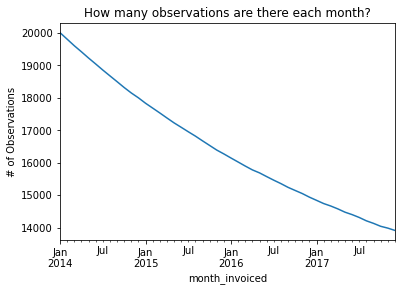

In [22]:
# Resample by Month and Plot
df.resample('M').size().plot()
plt.ylabel('# of Observations')
plt.title('How many observations are there each month?')

<AxesSubplot:xlabel='month_invoiced'>

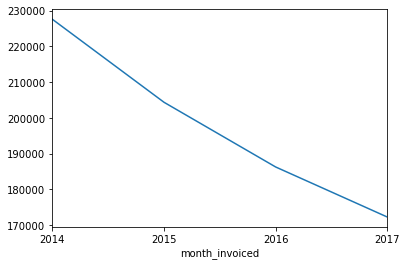

In [23]:
# resample data on yearly basis and plot
df.invoice_id.resample('Y').count().plot()
#plt.ylim(1200,1400)

[Text(0.5, 1.0, 'Revenue Over time'),
 Text(0, 0.5, 'Revenue'),
 Text(0.5, 0, '')]

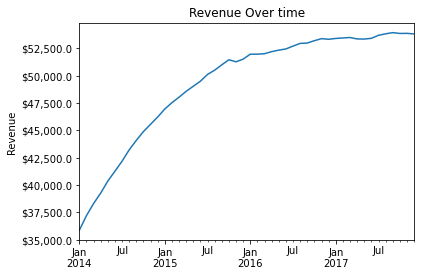

In [24]:
ax = df.resample('M').price.sum().plot()
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,}'))
ax.set(title='Revenue Over time', ylabel='Revenue', xlabel='')

<AxesSubplot:xlabel='month_invoiced'>

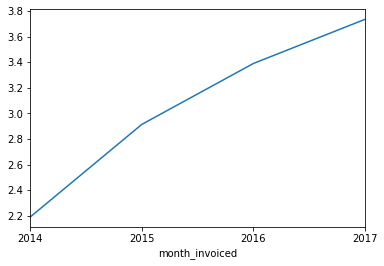

In [25]:
# resample data on yearly basis and plot
df.price.resample('Y').mean().plot()
#plt.ylim(1200,1400)

### Create a subseasonal plot by month of Average Price.

In [26]:
y = df.price
table = y.groupby([y.index.strftime('%Y'), y.index.strftime('%m-%b')]).mean().unstack()

table.head()

month_invoiced,01-Jan,02-Feb,03-Mar,04-Apr,05-May,06-Jun,07-Jul,08-Aug,09-Sep,10-Oct,11-Nov,12-Dec
month_invoiced,,,,,,,,,,,,
2014,1.792500,1.878283,1.953926,2.022099,2.099527,2.166982,2.237017,2.314160,2.383205,2.450718,2.510058,2.567793
2015,2.633070,2.687783,2.739589,2.794659,2.846154,2.895722,2.955873,3.002616,3.058305,3.112408,3.128089,3.166031
2016,3.218622,3.243336,3.271469,3.307980,3.335990,3.367478,3.408473,3.447737,3.476050,3.512282,3.546747,3.569420
2017,3.598046,3.625263,3.646778,3.660126,3.684974,3.708681,3.750699,3.787740,3.816078,3.835197,3.851269,3.866969


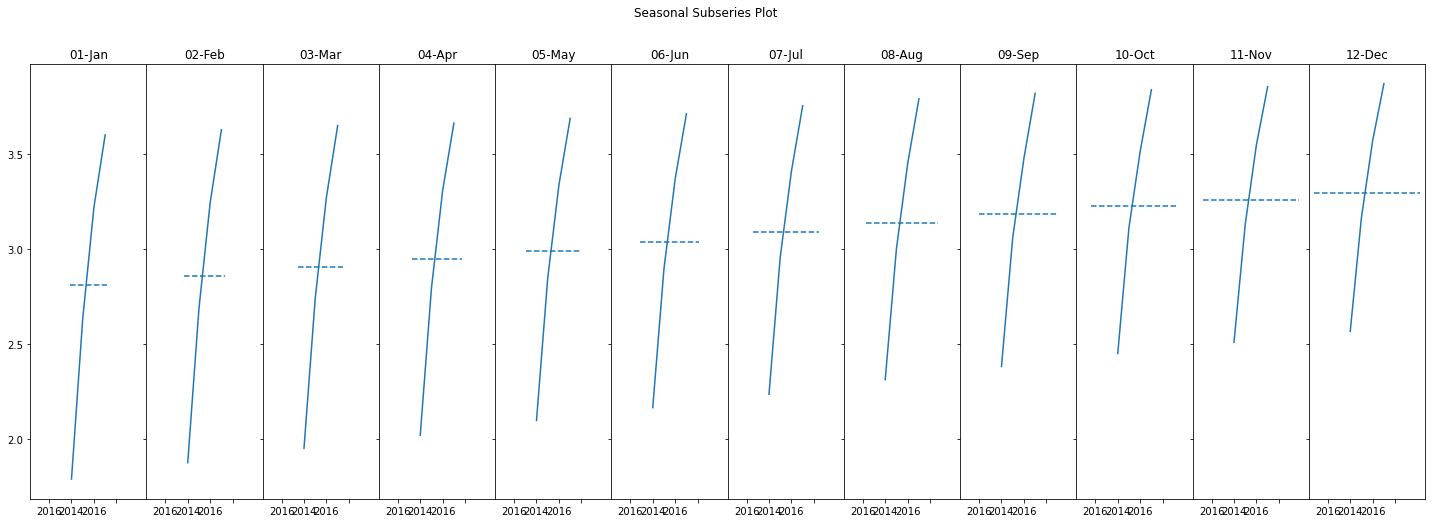

In [27]:
fig, axs = plt.subplots(1, 12, sharey=True, sharex=True, figsize=(25,8))
for ax, (month, subset) in zip(axs, table.iteritems()):
    subset.plot(ax=ax, title=month)
    x_left, x_right = ax.get_xlim()
    ax.hlines(subset.mean(), x_left, x_right, ls='--')
    ax.set(xlabel='')

fig.suptitle('Seasonal Subseries Plot') # super-title for the overall figure
fig.subplots_adjust(wspace=0)

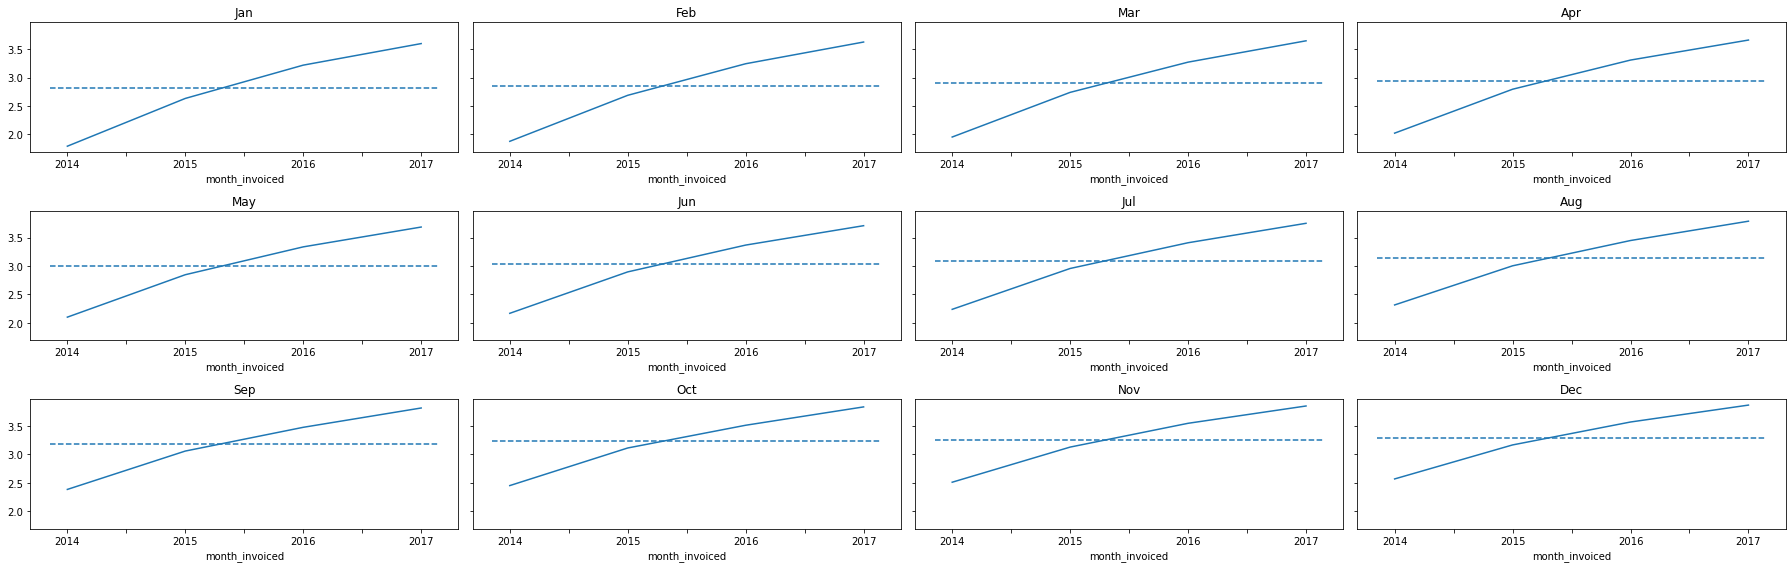

In [28]:
fig, axs = plt.subplots(3, 4, sharex=False, sharey=True, figsize=(25,8))

for ax, (month, subset) in zip(axs.ravel(), table.iteritems()):
    subset.plot(ax=ax, title=month[3:])
    ax.hlines(subset.mean(), *ax.get_xlim(), ls = '--')
fig.subplots_adjust(wspace=0)
plt.tight_layout()

### Create a subseasonal plot by month of Invoice Transaction count.

In [29]:
y = df.invoice_id
table = y.groupby([y.index.strftime('%Y'), y.index.strftime('%m-%b')]).count().unstack()

table.head()

month_invoiced,01-Jan,02-Feb,03-Mar,04-Apr,05-May,06-Jun,07-Jul,08-Aug,09-Sep,10-Oct,11-Nov,12-Dec
month_invoiced,,,,,,,,,,,,
2014,20000,19800,19599,19413,19221,19038,18851,18672,18494,18313,18145,17996
2015,17829,17680,17530,17376,17225,17089,16951,16817,16671,16529,16387,16268
2016,16142,16019,15895,15777,15685,15571,15460,15355,15240,15144,15049,14938
2017,14840,14741,14665,14576,14475,14400,14312,14209,14131,14041,13985,13914


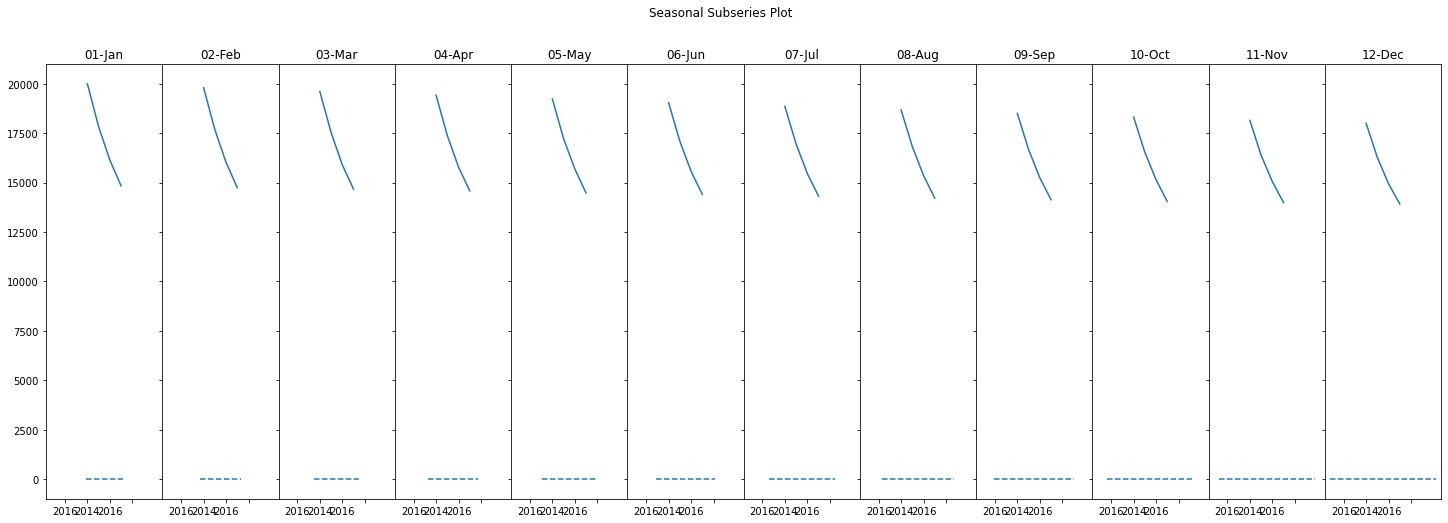

In [30]:
fig, axs = plt.subplots(1, 12, sharey=True, sharex=True, figsize=(25,8))
for ax, (month, subset) in zip(axs, table.iteritems()):
    subset.plot(ax=ax, title=month)
    x_left, x_right = ax.get_xlim()
    ax.hlines(subset.count(), x_left, x_right, ls='--')
    ax.set(xlabel='')

fig.suptitle('Seasonal Subseries Plot') # super-title for the overall figure
fig.subplots_adjust(wspace=0)

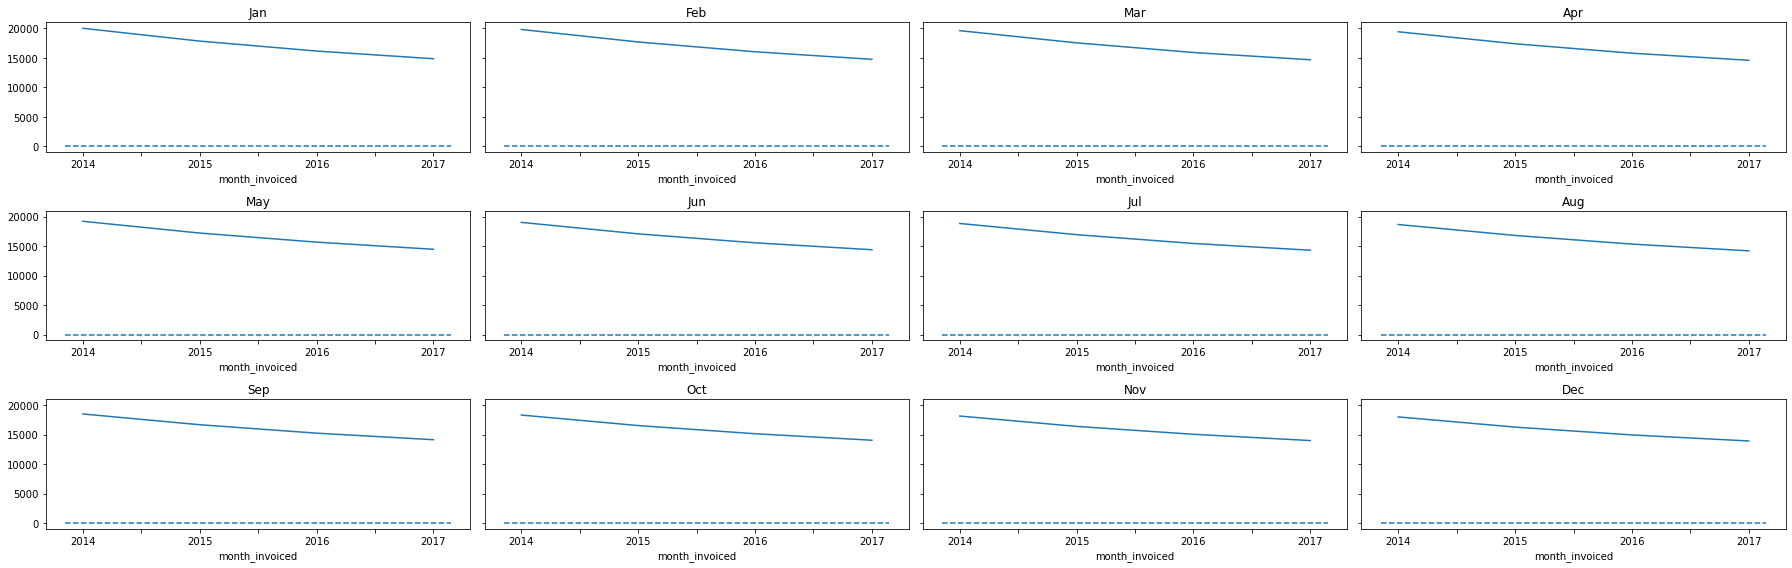

In [31]:
fig, axs = plt.subplots(3, 4, sharex=False, sharey=True, figsize=(25,8))

for ax, (month, subset) in zip(axs.ravel(), table.iteritems()):
    subset.plot(ax=ax, title=month[3:])
    ax.hlines(subset.count(), *ax.get_xlim(), ls = '--')
fig.subplots_adjust(wspace=0)
plt.tight_layout()

<div class="alert alert-info">


### Observations:
* It appears there is a downward trend on transactions
* But... there is an upward trend on price

<div class="alert alert-warning">


## 1. Split data (train/validate/test) and resample by any period except daily. Aggregate using the sum.

In [32]:
price = df.resample('M')[['price']].sum()

In [33]:
price.T

month_invoiced,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,...,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31
price,35850,37190,38295,39255,40355,41255,42170,43210,44075,44880,...,53480,53350,53340,53405,53680,53820,53925,53850,53860,53805


## Split

1. We will use the training proportion method to split.    
2. Identify the total length of the dataframe and multiply by `train_prop` to get the number of rows that equates to the first x% of the dataframe, which equates to the first x% of the time covered in the data.   (`x = train_prop * 100`)  
3. Select row indices from 0 up to the index representing x-percentile for train, and from the index representing x-percentile through the end of the dataframe for test. In both of these, we will reset the index in order to return dataframes sorted by datetime.  
4. Return train and test dataframes.  

In [34]:
int(len(price) * 0.5)

24

In [35]:
# set train size to be 50% of total 
train_size = int(len(price) * 0.5)
train_size

24

In [36]:
# set validate size to be 30% of total 
validate_size = int(len(price) * 0.3)
validate_size

14

In [37]:
# set test size to be number of rows remaining. 
test_size = int(len(price) - train_size - validate_size)
test_size

10

In [38]:
len(price) == train_size + validate_size + test_size

True

In [39]:
# set end for validate
validate_end_index = train_size + validate_size
validate_end_index

38

Use those values to split our dataframe

In [40]:
# train will go from 0 to 23
train = price[:train_size]

In [41]:
train.T

month_invoiced,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,...,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31
price,35850,37190,38295,39255,40355,41255,42170,43210,44075,44880,...,48025,48560,49025,49485,50105,50495,50985,51445,51260,51505


In [42]:
# validate will go from 24 to 37
validate = price[train_size:validate_end_index]

In [43]:
validate.T

month_invoiced,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28
price,51955,51955,52000,52190,52325,52435,52695,52940,52975,53190,53375,53320,53395,53440


In [44]:
# test will include 38 to the end
test = price[validate_end_index:]

In [45]:
train.size, validate.size, test.size

(24, 14, 10)

# Verify Splits

### Does the sum lengths of each train, validate, and test DataFrame equal the length of the original DataFrame? 

In [46]:
# is len of train + validate + test == lenght of entire dataframe. 
len(train) + len(validate) + len(test) == len(price)

True

In [47]:
# Do row counts of train + validate + test == row count of entire DataFrame? 
train.shape[0] + validate.shape[0] + test.shape[0] == price.shape[0]

True

### Is the first row of the original DataFrame and the first row of train the same? 

In [48]:
print(price.head(1) == train.head(1))

                price
month_invoiced       
2014-01-31       True


### Is the last row of train the day before the first row of validate?

In [49]:
pd.concat([train.tail(1), validate.head(1)])

,price
month_invoiced,
2015-12-31,51505
2016-01-31,51955


### Is the last row of validate the day before the first row of test?

In [50]:
pd.concat([validate.tail(1), test.head(1)])

,price
month_invoiced,
2017-02-28,53440
2017-03-31,53480


### Is the last row of test the same as the last row of original dataframe? 

In [51]:
pd.concat([test.tail(1), price.tail(1)])

,price
month_invoiced,
2017-12-31,53805
2017-12-31,53805


### Plot data, viewing where the data is split into train and test. 

In [52]:
train.columns

Index(['price'], dtype='object')

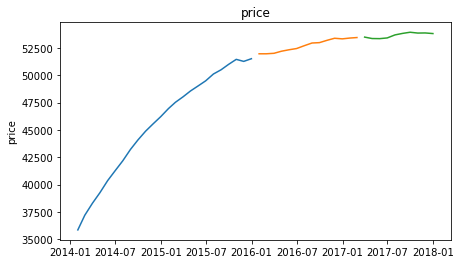

In [53]:
for col in train.columns:
    plt.figure(figsize=(7,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

<div class="alert alert-warning">


## 2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
* Simple Average
* Moving Average
* Holt's Linear Trend Model
* Based on previous year/month/etc., this is up to you.

#### attempted to write ambiguously enough to use outside this workbook
#### did not work so I am commenting it out by applying markdown to this cell

def evaluate(df, target_var, yhat_df):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(df[target_var], yhat_df[target_var])), 0)
    return rmse

def plot_and_eval(target_var, train, validate, yhat_df):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var], label=target_var)
    plt.title(target_var)
    plt.legend()
    rmse = evaluate(df, target_var, yhat_df)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [54]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var], label=target_var)
    plt.title(target_var)
    plt.legend()
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

Write `append_eval_df(model_type)` to append evaluation metrics for each model type, target variable, and metric type, along with the metric value into our `eval_df` data frame object. Which we will create an empty `eval_df` dataframe object to start. 

In [55]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [56]:
# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

<div class="alert alert-warning">


## Last Observed Value

In [57]:
# take the last item of amount and assign to variable
last_observed_value = train['price'][-1:][0]
last_observed_value

51505

In [58]:
# assign that variable value to a new yhat DataFrame as the last_observed_value prediction
yhat_df = pd.DataFrame(
    {'price': [last_observed_value]},
    index=validate.index)

yhat_df

,price
month_invoiced,
2016-01-31,51505
2016-02-29,51505
2016-03-31,51505
2016-04-30,51505
2016-05-31,51505
2016-06-30,51505
2016-07-31,51505
2016-08-31,51505
2016-09-30,51505


In [60]:
# Check that all values are the same
yhat_df.price.unique()

array([51505])

price -- RMSE: 1343


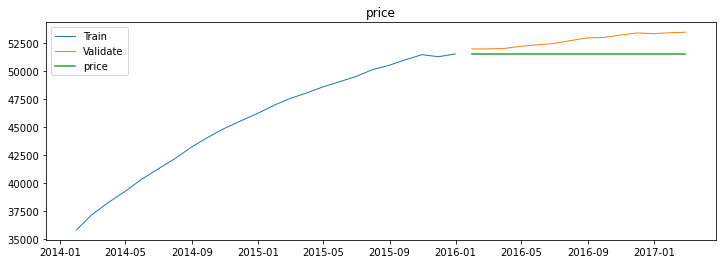

In [61]:
# plot
plot_and_eval('price')

In [62]:
# evaluate
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,price,1343.0


<div class="alert alert-warning">


## Simple Average
* Take the simple average of historical values and use that value to predict future values.   

* This is a good option for an initial baseline. Every future datapoint (those in 'test') will be assigned the same value, and that value will be the overall mean of the values in train. 

In [63]:
# compute simple average
simple_avg = round(train['price'].mean(), 2)
simple_avg

45568.54

In [64]:
# assign that variable value to the yhat DataFrame as the simple_avg prediction
def make_predictions(simple_avg=None):
    yhat_df = pd.DataFrame({'price': [simple_avg]},
                          index=validate.index)
    return yhat_df

In [65]:
# reassign yhat DataFrame
yhat_df = make_predictions(simple_avg)

In [66]:
yhat_df.head()

,price
month_invoiced,
2016-01-31,45568.54
2016-02-29,45568.54
2016-03-31,45568.54
2016-04-30,45568.54
2016-05-31,45568.54


In [67]:
# Check that all values are the same
yhat_df.price.unique()

array([45568.54])

price -- RMSE: 7181


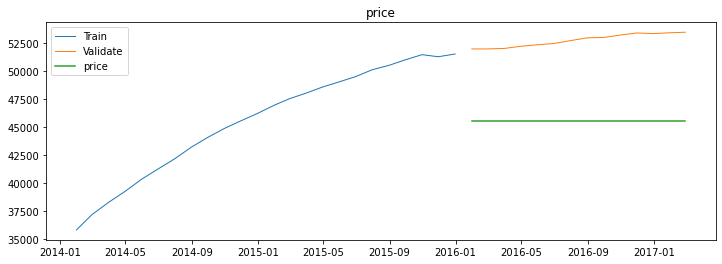

In [68]:
# plot
for col in train.columns:
    plot_and_eval(col)

In [69]:
# append predictions to yhat_df
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,price,1343.0
1,simple_average,price,7181.0


<div class="alert alert-warning">


## Moving Average

In [70]:
# Take a look at a 3 month rolling mean
period=3
train['price'].rolling(period).mean()[-1]

51403.333333333336

In [71]:
# take 90 day rolling average, take last value as our yhat prediction. 
period = 3
moving_avg = round(train['price'].rolling(period).mean()[-1], 2)
print(moving_avg)

51403.33


In [72]:
# reassign yhat DataFrame
yhat_df = make_predictions(moving_avg)
yhat_df.head()

,price
month_invoiced,
2016-01-31,51403.33
2016-02-29,51403.33
2016-03-31,51403.33
2016-04-30,51403.33
2016-05-31,51403.33


price -- RMSE: 1436


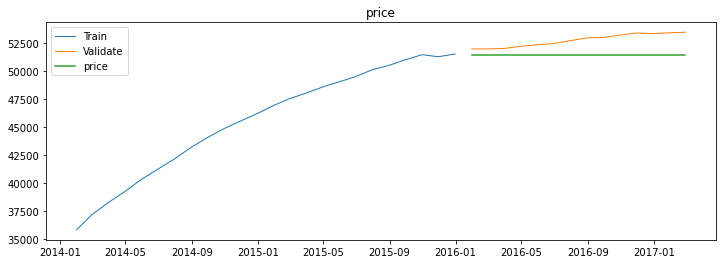

In [73]:
# Plot
for col in train.columns:
    plot_and_eval(col)

In [74]:
# Append eval DataFrame
for col in train.columns:
    eval_df = append_eval_df(model_type = '3_month_moving_avg', 
                            target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,price,1343.0
1,simple_average,price,7181.0
2,3_month_moving_avg,price,1436.0


In [75]:
# Apply other rolling periods
periods = [1, 3, 6, 9, 12]

for p in periods: 
    moving_avg = round(train['price'].rolling(p).mean()[-1], 2)
    yhat_df = make_predictions(moving_avg)
    model_type = str(p) + '_month_moving_avg'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type,
                                target_var = col)

In [76]:
# show results
eval_df

,model_type,target_var,rmse
0,last_observed_value,price,1343.0
1,simple_average,price,7181.0
2,3_month_moving_avg,price,1436.0
3,1_month_moving_avg,price,1343.0
4,3_month_moving_avg,price,1436.0
5,6_month_moving_avg,price,1847.0
6,9_month_moving_avg,price,2473.0
7,12_month_moving_avg,price,3164.0


In [77]:
# Assign min rmse
min_rmse = eval_df[eval_df.target_var == 'amount']['rmse'].min()

In [78]:
# show it
min_rmse

nan

In [79]:
# show DataFrame for just min rmse
eval_df[eval_df.rmse == min_rmse]

,model_type,target_var,rmse


In [80]:
# show entire DataFrame sorted by RMSE
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
0,last_observed_value,price,1343.0
3,1_month_moving_avg,price,1343.0
2,3_month_moving_avg,price,1436.0
4,3_month_moving_avg,price,1436.0
5,6_month_moving_avg,price,1847.0
6,9_month_moving_avg,price,2473.0
7,12_month_moving_avg,price,3164.0
1,simple_average,price,7181.0


<div class="alert alert-warning">


## Holt's Linear Trend Model
* Exponential smoothing applied to both the average and the trend (slope).  

- $\alpha$ / smoothing_level: smoothing parameter for mean. Values closer to 1 will have less of a smoothing effect and will give greater weight to recent values.   
- $\beta$ / smoothing_slope: smoothing parameter for the slope. Values closer to 1 will give greater weight to recent slope/values. 



**Seasonal Decomposition**
    
Holt: 

- exponential = True/False (exponential vs. linear growth, additive vs. multiplicative)
- damped $\phi$ = True/False: with Holt, forecasts will increase or decrease indefinitely into the future.  To avoid this, use the Damped trend method which has a damping parameter 0< ϕ <1. 


fit: 

- smoothing_level ($\alpha$): value between (0,1)
- smoothing_slope ($\beta$): value between (0,1)
- optimized: use the auto-optimization that allow statsmodels to automatically find an optimized value for us. 


In [81]:
# Required Import
import statsmodels.api as sm

price 



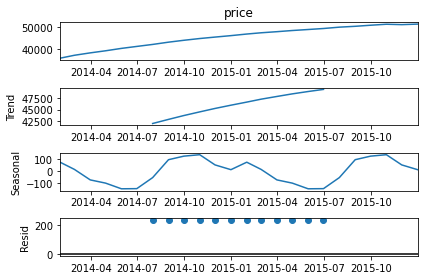

In [82]:
# Show various time plots
print(col, '\n')
sm.tsa.seasonal_decompose(train[col].resample('M').mean()).plot()
plt.show()

In [83]:
# create our Holt's Object
col = 'price' 
model = Holt(train[col], exponential=False, damped=True)

In [84]:
# fit the holt's object
model = model.fit(optimized=True)

In [85]:
# Predict
yhat_items = model.predict(start = validate.index[0],
                              end = validate.index[-1])

In [86]:
# assign to yhat DataFrame
yhat_df[col] = round(yhat_items, 2)

In [87]:
yhat_df

,price
month_invoiced,
2016-01-31,51748.62
2016-02-29,51962.00
2016-03-31,52173.35
2016-04-30,52382.69
2016-05-31,52590.04
2016-06-30,52795.43
2016-07-31,52998.86
2016-08-31,53200.36
2016-09-30,53399.95


**Plot Actual vs. Predicted Values**

price -- RMSE: 456


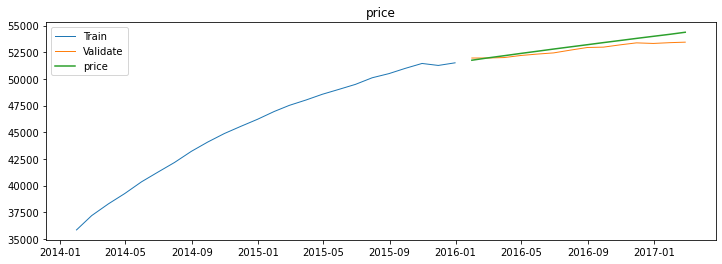

In [88]:
# Plot yhat predictions vs actual
plot_and_eval(target_var = col)

In [89]:
# append eval DataFrame
eval_df = append_eval_df(model_type = 'holts_optimized', 
                            target_var = col)

In [90]:
# Display eval DataFrame sorted by RMSE
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
8,holts_optimized,price,456.0
0,last_observed_value,price,1343.0
3,1_month_moving_avg,price,1343.0
2,3_month_moving_avg,price,1436.0
4,3_month_moving_avg,price,1436.0
5,6_month_moving_avg,price,1847.0
6,9_month_moving_avg,price,2473.0
7,12_month_moving_avg,price,3164.0
1,simple_average,price,7181.0


<div class="alert alert-warning">


## Based on Cycle
* previous year/month/etc., this is up to you.

    
Take all the 2016 data points, compute the daily delta, year-over-year, average that delta over all the days, and adding that average to the previous year's value on a day will give you the forecast for that day. 

If a primary cycle is weekly, then you may want to do this on a week-over-week cadence. 

In the below example:  
1. Compute the 365 average year over year differences from 2013 through 2015
2. Add that average delta to the values during 2015. 
3. Set the index in your yhat dataframe to represent the dates those predictions are make for. 

**Re-split data**

In [91]:
df = df.resample('M')[['price']].sum()

In [92]:
df.index

DatetimeIndex(['2014-01-31', '2014-02-28', '2014-03-31', '2014-04-30',
               '2014-05-31', '2014-06-30', '2014-07-31', '2014-08-31',
               '2014-09-30', '2014-10-31', '2014-11-30', '2014-12-31',
               '2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30',
               '2015-05-31', '2015-06-30', '2015-07-31', '2015-08-31',
               '2015-09-30', '2015-10-31', '2015-11-30', '2015-12-31',
               '2016-01-31', '2016-02-29', '2016-03-31', '2016-04-30',
               '2016-05-31', '2016-06-30', '2016-07-31', '2016-08-31',
               '2016-09-30', '2016-10-31', '2016-11-30', '2016-12-31',
               '2017-01-31', '2017-02-28', '2017-03-31', '2017-04-30',
               '2017-05-31', '2017-06-30', '2017-07-31', '2017-08-31',
               '2017-09-30', '2017-10-31', '2017-11-30', '2017-12-31'],
              dtype='datetime64[ns]', name='month_invoiced', freq='M')

In [93]:
train = df[:'2015']
validate = df['2016']
test = df['2017']

print(train.shape)
print(validate.shape)
print(test.shape)

train.head()

(24, 1)
(12, 1)
(12, 1)


,price
month_invoiced,
2014-01-31,35850
2014-02-28,37190
2014-03-31,38295
2014-04-30,39255
2014-05-31,40355


In [94]:
# finding the year-over-year difference for each day from 2013 to 2015
# taking the mean, and then adding that value to the daily 2015 values. 

# find your difference from 2013-2014 and 2014-2015, take the mean, and add to each value in 2015. 
yhat_df = train['2015'] + train.diff(12).mean()

In [95]:
# look at train 2015 index
train.loc['2015'].head()

,price
month_invoiced,
2015-01-31,46945
2015-02-28,47520
2015-03-31,48025
2015-04-30,48560
2015-05-31,49025


In [96]:
# look at yhat head
yhat_df.head()

,price
month_invoiced,
2015-01-31,55033.75
2015-02-28,55608.75
2015-03-31,56113.75
2015-04-30,56648.75
2015-05-31,57113.75


In [97]:
# look at validate head
validate.head()

,price
month_invoiced,
2016-01-31,51955
2016-02-29,51955
2016-03-31,52000
2016-04-30,52190
2016-05-31,52325


In [98]:
# let's peek into the prediction we will make for 1/1/2016
# by comparing the predicted value 
# (2015 value + year-over-year average difference)
# to the actual 1/1/2016 value
pd.concat([yhat_df.head(1), validate.head(1)])

,price
month_invoiced,
2015-01-31,55033.75
2016-01-31,51955.00


In [99]:
# set yhat_df to index of validate
yhat_df.index = validate.index

In [100]:
yhat_df.describe()

,price
count,12.000000
mean,57701.666667
std,1596.656248
min,55033.750000
25%,56515.000000
50%,57883.750000
75%,59142.500000
max,59593.750000


In [101]:
yhat_df.head()

,price
month_invoiced,
2016-01-31,55033.75
2016-02-29,55608.75
2016-03-31,56113.75
2016-04-30,56648.75
2016-05-31,57113.75


In [102]:
yhat_df.shape

(12, 1)

price -- RMSE: 5192


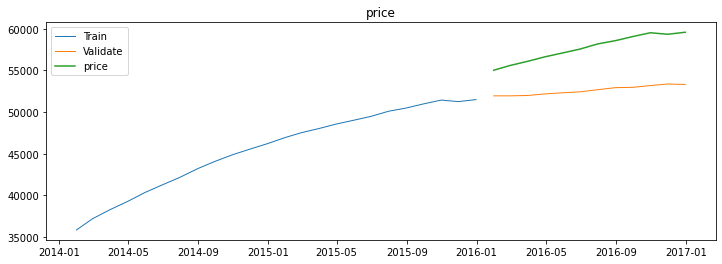

In [103]:
# Plot and Evaluate
plot_and_eval(target_var = col)
eval_df = append_eval_df(model_type = "previous_year", 
                            target_var = col)

In [104]:
# Display eval DataFrame sorted by RMSE to find best performing model
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
8,holts_optimized,price,456.0
0,last_observed_value,price,1343.0
3,1_month_moving_avg,price,1343.0
2,3_month_moving_avg,price,1436.0
4,3_month_moving_avg,price,1436.0
5,6_month_moving_avg,price,1847.0
6,9_month_moving_avg,price,2473.0
7,12_month_moving_avg,price,3164.0
9,previous_year,price,5192.0
1,simple_average,price,7181.0


In [105]:
# Create yhat variable for test predictions
yhat_items = model.predict(start = test.index[0],
                              end = test.index[-1])

In [106]:
# Create yhat DataFrame using test and replace price with predictions
yhat_df = pd.DataFrame(index=test.index, columns=test.columns)
yhat_df.price = yhat_items

In [107]:
yhat_df

,price
month_invoiced,
2017-01-31,54179.514829
2017-02-28,54369.799440
2017-03-31,54558.276350
2017-04-30,54744.962734
2017-05-31,54929.875601
2017-06-30,55113.031800
2017-07-31,55294.448019
2017-08-31,55474.140787
2017-09-30,55652.126478


In [108]:
# Create Function to show final plot with train, val, test, and predictions

def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5, label='prediction')
    plt.title(target_var)
    plt.legend()
    plt.show()

In [109]:
# Store RMSE result between test and yhat
rmse_amount = sqrt(mean_squared_error(test['price'], 
                                       yhat_df['price']))

In [110]:
# show the answer in human readable print
print('rmse-amount: ', rmse_amount)

rmse-amount:  1645.3897303951746


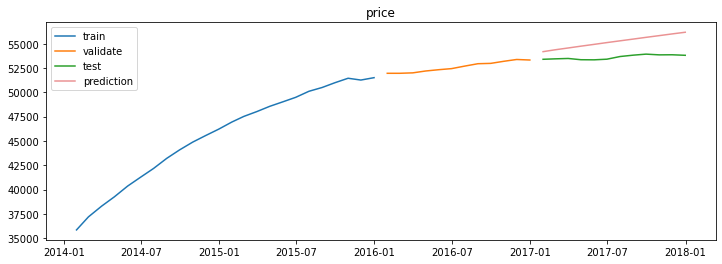

In [111]:
# Show final plot using custom function
final_plot(col)

In [112]:
# to predict 2018, create yhat DataFrame with new index 1 year later
yhat_df.index = test.index + pd.Timedelta('1Y')

In [113]:
yhat_df

,price
month_invoiced,
2018-01-31 05:49:12,54179.514829
2018-02-28 05:49:12,54369.799440
2018-03-31 05:49:12,54558.276350
2018-04-30 05:49:12,54744.962734
2018-05-31 05:49:12,54929.875601
2018-06-30 05:49:12,55113.031800
2018-07-31 05:49:12,55294.448019
2018-08-31 05:49:12,55474.140787
2018-09-30 05:49:12,55652.126478


In [114]:
# Create yhat variable for test predictions on test index
yhat = model.predict(start = test.index[0],
                              end = test.index[-1])

In [115]:
# show the new test predictions variable
yhat

2017-01-31    54179.514829
2017-02-28    54369.799440
2017-03-31    54558.276350
2017-04-30    54744.962734
2017-05-31    54929.875601
2017-06-30    55113.031800
2017-07-31    55294.448019
2017-08-31    55474.140787
2017-09-30    55652.126478
2017-10-31    55828.421309
2017-11-30    56003.041342
2017-12-31    56176.002489
Freq: M, dtype: float64

In [116]:
# overwrite the current yhat DataFrame target with the 2017 predicted values captured in the yhat variable
yhat_df.price = yhat.values

In [117]:
yhat_df

,price
month_invoiced,
2018-01-31 05:49:12,54179.514829
2018-02-28 05:49:12,54369.799440
2018-03-31 05:49:12,54558.276350
2018-04-30 05:49:12,54744.962734
2018-05-31 05:49:12,54929.875601
2018-06-30 05:49:12,55113.031800
2018-07-31 05:49:12,55294.448019
2018-08-31 05:49:12,55474.140787
2018-09-30 05:49:12,55652.126478


In [118]:
# Create another final plot function
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5, label='projection')
    plt.title(target_var)
    plt.legend()
    plt.show()

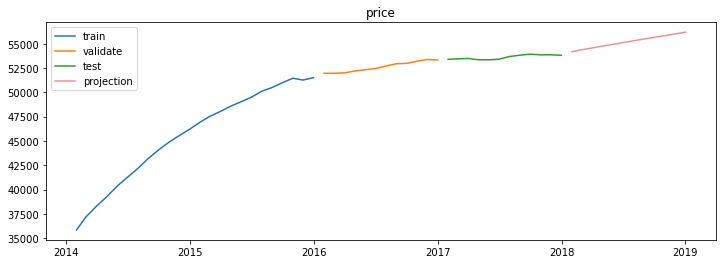

In [119]:
# show polot using function in loop
for col in train.columns:
    final_plot(col)

<div class="alert alert-danger">

    
# Bonus

<div class="alert alert-success">


# ```store``` dataset

<div class="alert alert-warning">


## 1. Predict 2018 total **monthly** sales for a single store and/or item by creating a model.

<div class="alert alert-warning">


## 2. Return a dataframe with the month, store_id, y-hat, and the confidence intervals (y-hat lower, y-hat upper). The upper and lower bounds of the predictions are auto generated when using the facebook prophet model, or you could calculate your own using, for example, ```bollinger bands```.

<div class="alert alert-warning">


## 3. Plot the 2018 monthly sales predictions.